# 30-Day Hospital Readmission Prediction - Results Visualization

This notebook generates comprehensive visualizations for the readmission prediction models.

**Author:** Yuchen Zhou  
**Course:** CS526 - Fall 2025  
**Dataset:** MIMIC-IV  
**Models:** Logistic Regression, Random Forest, XGBoost, LSTM, Transformer

## 1. Setup and Import Libraries

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
sns.set_context("notebook", font_scale=1.2)

# Set figure DPI for better quality
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 2. Load Data

In [14]:
# Define paths
reports_dir = Path('training/reports')
artifacts_dir = Path('training/artifacts')

# Load metrics
metrics_df = pd.read_csv(reports_dir / 'metrics.csv')

# Get unique models and their average metrics
model_metrics = metrics_df.groupby('model').agg({
    'roc_auc': 'mean',
    'pr_auc': 'mean',
    'accuracy': 'mean',
    'precision': 'mean',
    'recall': 'mean',
    'f1': 'mean',
    'specificity': 'mean'
}).reset_index()

# Sort by ROC-AUC
model_metrics = model_metrics.sort_values('roc_auc', ascending=False)

print("📊 Model Performance Summary:")
print("=" * 80)
display(model_metrics.round(4))
print("\n✅ Data loaded successfully!")

📊 Model Performance Summary:


,model,roc_auc,pr_auc,accuracy,precision,recall,f1,specificity
3,TRANSFORMER,0.7056,0.4778,0.7484,0.6520,0.1255,0.2104,0.9756
4,XGB,0.7034,0.4748,0.6252,0.3865,0.6852,0.4942,0.6034
1,LSTM,0.7030,0.4723,0.7483,0.6256,0.1450,0.2354,0.9684
2,RF,0.6938,0.4620,0.6409,0.3925,0.6274,0.4829,0.6458
0,LR,0.6626,0.4037,0.5918,0.3576,0.6621,0.4643,0.5662



✅ Data loaded successfully!


## 3. Model Performance Comparison

### 3.1 Overall Performance Bar Chart

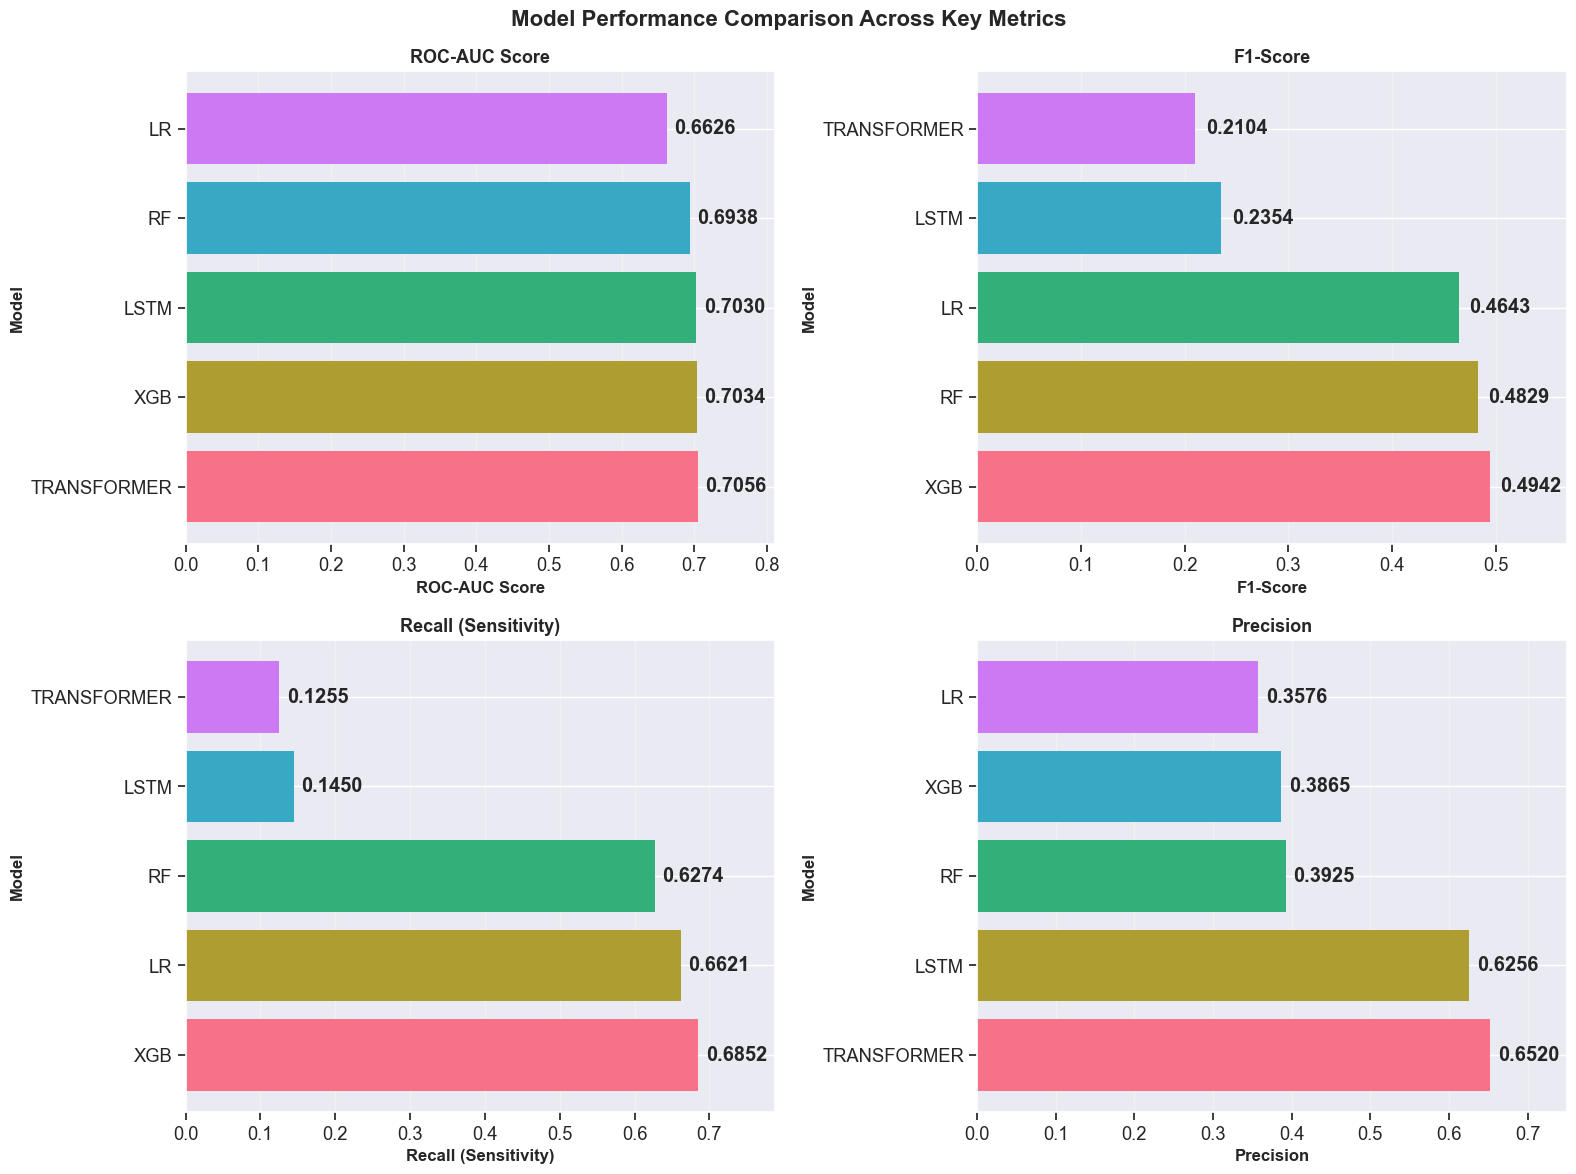

✅ Comprehensive comparison chart saved!


In [15]:
# Create comprehensive performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison Across Key Metrics', fontsize=16, fontweight='bold')

metrics_to_plot = [
    ('roc_auc', 'ROC-AUC Score', axes[0, 0]),
    ('f1', 'F1-Score', axes[0, 1]),
    ('recall', 'Recall (Sensitivity)', axes[1, 0]),
    ('precision', 'Precision', axes[1, 1])
]

colors = sns.color_palette("husl", len(model_metrics))

for metric, title, ax in metrics_to_plot:
    sorted_data = model_metrics.sort_values(metric, ascending=False)
    bars = ax.barh(sorted_data['model'], sorted_data[metric], color=colors)
    
    # Add value labels
    for i, (idx, row) in enumerate(sorted_data.iterrows()):
        ax.text(row[metric] + 0.01, i, f"{row[metric]:.4f}", 
                va='center', fontweight='bold')
    
    ax.set_xlabel(title, fontsize=12, fontweight='bold')
    ax.set_ylabel('Model', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(0, max(sorted_data[metric]) * 1.15)

plt.tight_layout()
plt.savefig(reports_dir / 'comprehensive_model_comparison.png', bbox_inches='tight')
plt.show()

print("✅ Comprehensive comparison chart saved!")

### 3.2 Radar Chart for Multi-Metric Comparison

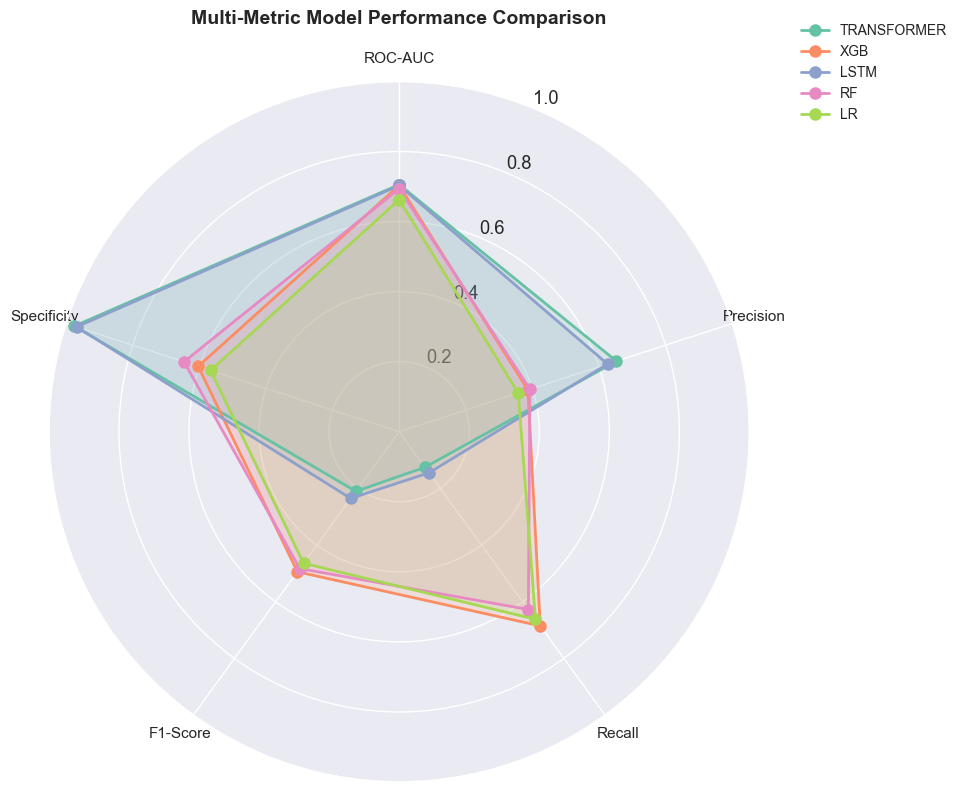

✅ Radar chart saved!


In [16]:
from math import pi

# Prepare data for radar chart
metrics_radar = ['roc_auc', 'precision', 'recall', 'f1', 'specificity']
metrics_labels = ['ROC-AUC', 'Precision', 'Recall', 'F1-Score', 'Specificity']

# Create radar chart
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

angles = [n / float(len(metrics_labels)) * 2 * pi for n in range(len(metrics_labels))]
angles += angles[:1]

ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics_labels, size=11)
ax.set_ylim(0, 1)

# Plot each model
colors_radar = sns.color_palette("Set2", len(model_metrics))
for idx, (_, row) in enumerate(model_metrics.iterrows()):
    values = [row[m] for m in metrics_radar]
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=row['model'], 
            color=colors_radar[idx], markersize=8)
    ax.fill(angles, values, alpha=0.15, color=colors_radar[idx])

ax.set_title('Multi-Metric Model Performance Comparison', 
             size=14, fontweight='bold', pad=20)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
ax.grid(True)

plt.tight_layout()
plt.savefig(reports_dir / 'radar_chart_comparison.png', bbox_inches='tight')
plt.show()

print("✅ Radar chart saved!")

## 4. Confusion Matrix Analysis

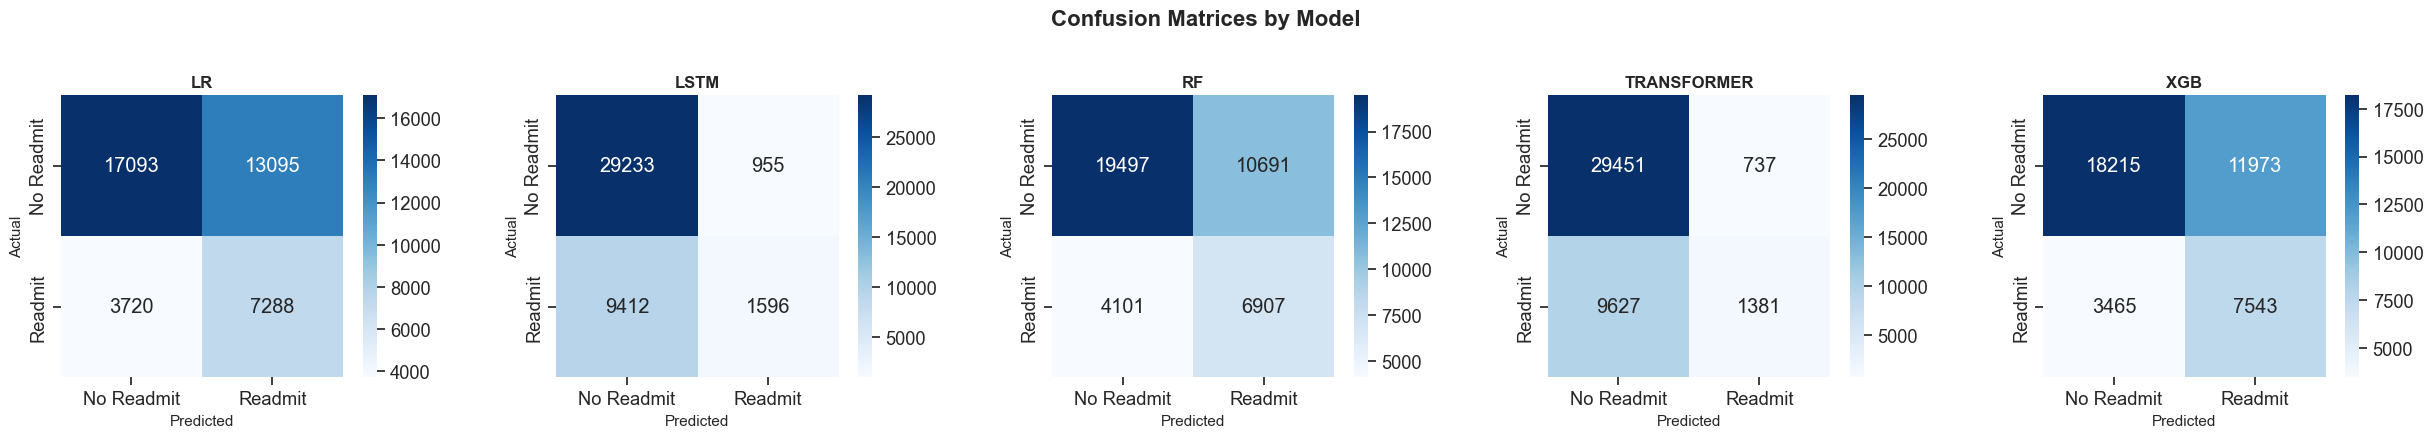

✅ Confusion matrices visualization saved!


In [17]:
# Extract confusion matrix data
cm_data = metrics_df.groupby('model').agg({
    'true_negatives': 'mean',
    'false_positives': 'mean',
    'false_negatives': 'mean',
    'true_positives': 'mean'
}).reset_index()

# Create confusion matrix heatmaps
n_models = len(cm_data)
fig, axes = plt.subplots(1, n_models, figsize=(5*n_models, 4))
if n_models == 1:
    axes = [axes]

fig.suptitle('Confusion Matrices by Model', fontsize=16, fontweight='bold', y=1.05)

for idx, (_, row) in enumerate(cm_data.iterrows()):
    cm = np.array([
        [row['true_negatives'], row['false_positives']],
        [row['false_negatives'], row['true_positives']]
    ])
    
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', 
                xticklabels=['No Readmit', 'Readmit'],
                yticklabels=['No Readmit', 'Readmit'],
                ax=axes[idx], cbar=True, square=True)
    
    axes[idx].set_title(f"{row['model']}", fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=11)
    axes[idx].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.savefig(reports_dir / 'confusion_matrices_comparison.png', bbox_inches='tight')
plt.show()

print("✅ Confusion matrices visualization saved!")

## 5. Precision-Recall Trade-off Analysis

/var/folders/v0/1lrkgf3s4d3_x4q14m3pmy840000gn/T/ipykernel_62974/2057449777.py:27: RuntimeWarning: divide by zero encountered in divide
  precision_range = f1 * recall_range / (2 * recall_range - f1)


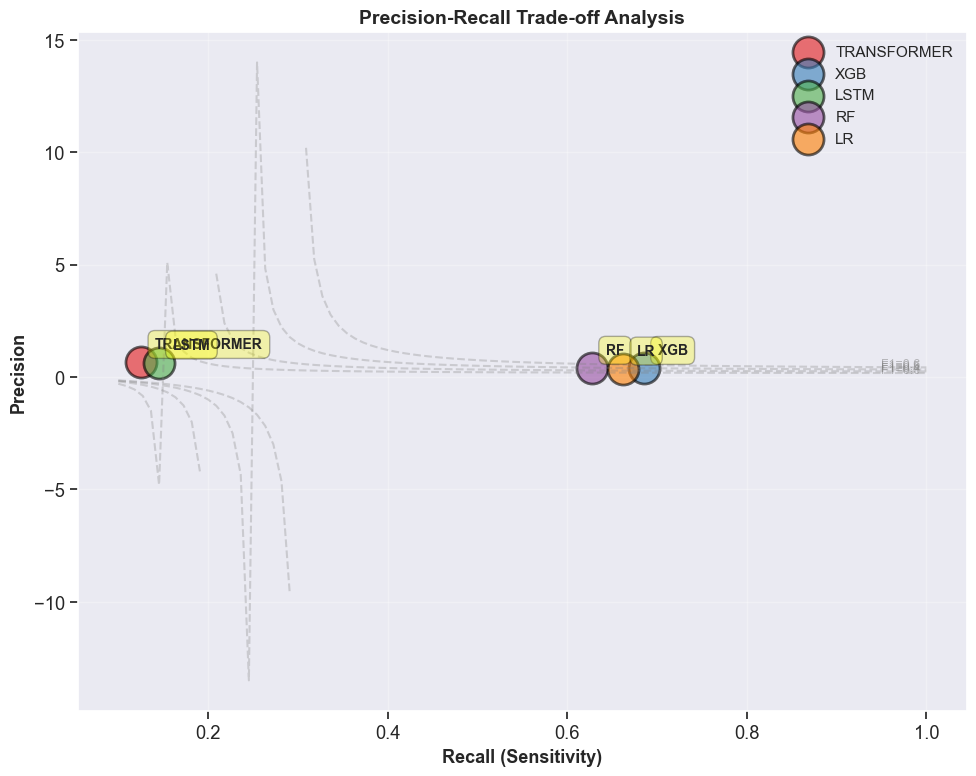

✅ Precision-Recall trade-off chart saved!


In [18]:
# Precision vs Recall scatter plot
fig, ax = plt.subplots(figsize=(10, 8))

colors_scatter = sns.color_palette("Set1", len(model_metrics))
for idx, (_, row) in enumerate(model_metrics.iterrows()):
    ax.scatter(row['recall'], row['precision'], 
              s=500, alpha=0.6, color=colors_scatter[idx],
              edgecolors='black', linewidth=2,
              label=row['model'])
    
    # Add model name annotation
    ax.annotate(row['model'], 
               (row['recall'], row['precision']),
               xytext=(10, 10), textcoords='offset points',
               fontsize=10, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.3))

ax.set_xlabel('Recall (Sensitivity)', fontsize=13, fontweight='bold')
ax.set_ylabel('Precision', fontsize=13, fontweight='bold')
ax.set_title('Precision-Recall Trade-off Analysis', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=11)

# Add F1 contour lines
recall_range = np.linspace(0.1, 1, 100)
for f1 in [0.3, 0.4, 0.5, 0.6]:
    precision_range = f1 * recall_range / (2 * recall_range - f1)
    ax.plot(recall_range, precision_range, '--', alpha=0.3, color='gray')
    ax.text(0.95, f1*0.95/(2*0.95-f1), f'F1={f1:.1f}', 
           fontsize=9, alpha=0.5, color='gray')

plt.tight_layout()
plt.savefig(reports_dir / 'precision_recall_tradeoff.png', bbox_inches='tight')
plt.show()

print("✅ Precision-Recall trade-off chart saved!")

## 6. Model Performance Ranking

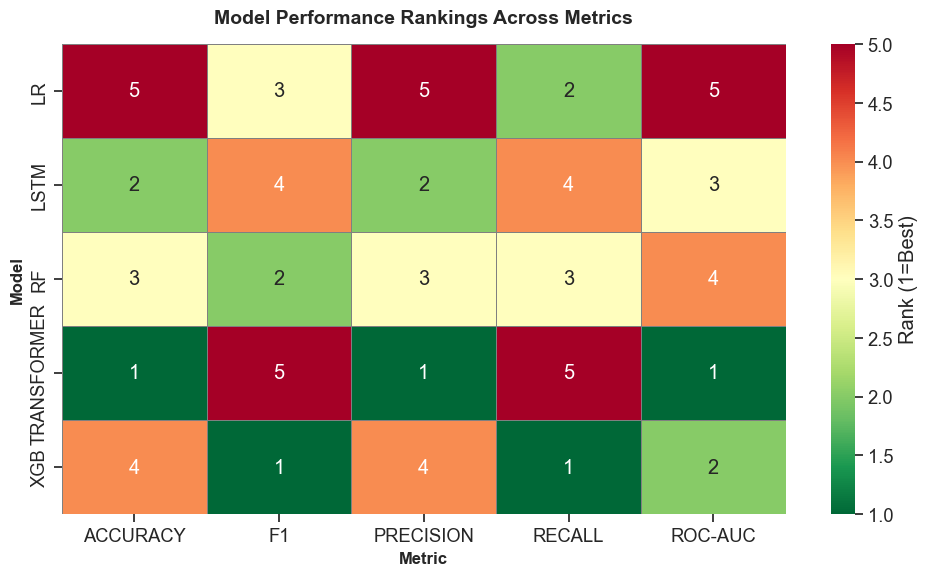

✅ Rankings heatmap saved!


In [19]:
# Create ranking table
ranking_metrics = ['roc_auc', 'f1', 'recall', 'precision', 'accuracy']
ranking_data = []

for metric in ranking_metrics:
    sorted_models = model_metrics.sort_values(metric, ascending=False)
    for rank, (_, row) in enumerate(sorted_models.iterrows(), 1):
        ranking_data.append({
            'Metric': metric.upper().replace('_', '-'),
            'Rank': rank,
            'Model': row['model'],
            'Score': row[metric]
        })

ranking_df = pd.DataFrame(ranking_data)

# Create heatmap of rankings
pivot_rankings = ranking_df.pivot_table(
    index='Model', 
    columns='Metric', 
    values='Rank'
)

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot_rankings, annot=True, fmt='.0f', cmap='RdYlGn_r',
           cbar_kws={'label': 'Rank (1=Best)'}, ax=ax,
           linewidths=0.5, linecolor='gray')

ax.set_title('Model Performance Rankings Across Metrics', 
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(reports_dir / 'model_rankings_heatmap.png', bbox_inches='tight')
plt.show()

print("✅ Rankings heatmap saved!")

## 7. Statistical Summary Table

In [20]:
# Create detailed summary table
summary_table = model_metrics[['model', 'roc_auc', 'pr_auc', 'accuracy', 
                                'precision', 'recall', 'f1', 'specificity']].copy()

# Add ranking indicators
summary_table['Best Metric'] = summary_table.apply(
    lambda row: ', '.join([
        metric.upper() for metric in ['roc_auc', 'f1', 'recall', 'precision']
        if row[metric] == model_metrics[metric].max()
    ]), axis=1
)

# Format for display
display_table = summary_table.copy()
for col in ['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'specificity']:
    display_table[col] = display_table[col].apply(lambda x: f"{x:.4f}")

print("\n" + "="*100)
print("📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("="*100)
display(display_table)

# Save to CSV
summary_table.to_csv(reports_dir / 'model_summary_statistics.csv', index=False)
print("\n✅ Summary statistics saved to CSV!")


📊 COMPREHENSIVE MODEL PERFORMANCE SUMMARY


,model,roc_auc,pr_auc,accuracy,precision,recall,f1,specificity,Best Metric
3,TRANSFORMER,0.7056,0.4778,0.7484,0.6520,0.1255,0.2104,0.9756,"ROC_AUC, PRECISION"
4,XGB,0.7034,0.4748,0.6252,0.3865,0.6852,0.4942,0.6034,"F1, RECALL"
1,LSTM,0.7030,0.4723,0.7483,0.6256,0.1450,0.2354,0.9684,
2,RF,0.6938,0.4620,0.6409,0.3925,0.6274,0.4829,0.6458,
0,LR,0.6626,0.4037,0.5918,0.3576,0.6621,0.4643,0.5662,



✅ Summary statistics saved to CSV!


## 8. Best Model Recommendation

In [21]:
# Determine best model for different scenarios
best_auc = model_metrics.loc[model_metrics['roc_auc'].idxmax()]
best_f1 = model_metrics.loc[model_metrics['f1'].idxmax()]
best_recall = model_metrics.loc[model_metrics['recall'].idxmax()]
best_precision = model_metrics.loc[model_metrics['precision'].idxmax()]

recommendations = f"""
{'='*80}
🏆 MODEL RECOMMENDATIONS
{'='*80}

📈 BEST OVERALL PERFORMANCE (ROC-AUC):
   Model: {best_auc['model']}
   ROC-AUC: {best_auc['roc_auc']:.4f}
   Use Case: General-purpose readmission prediction

⚖️  BEST BALANCED PERFORMANCE (F1-Score):
   Model: {best_f1['model']}
   F1-Score: {best_f1['f1']:.4f}
   Use Case: When balancing precision and recall is important

🎯 BEST PATIENT CAPTURE (Recall):
   Model: {best_recall['model']}
   Recall: {best_recall['recall']:.4f}
   Use Case: Minimize missed readmissions (preventive care)

✅ BEST ACCURACY (Precision):
   Model: {best_precision['model']}
   Precision: {best_precision['precision']:.4f}
   Use Case: Minimize false alarms (resource allocation)

{'='*80}
💡 PRODUCTION RECOMMENDATION:
   Primary Model: {best_f1['model']} (Best F1-Score)
   Alternative: {best_auc['model']} (Highest ROC-AUC)
{'='*80}
"""

print(recommendations)

# Save recommendations
with open(reports_dir / 'model_recommendations.txt', 'w') as f:
    f.write(recommendations)

print("✅ Recommendations saved to file!")


🏆 MODEL RECOMMENDATIONS

📈 BEST OVERALL PERFORMANCE (ROC-AUC):
   Model: TRANSFORMER
   ROC-AUC: 0.7056
   Use Case: General-purpose readmission prediction

⚖️  BEST BALANCED PERFORMANCE (F1-Score):
   Model: XGB
   F1-Score: 0.4942
   Use Case: When balancing precision and recall is important

🎯 BEST PATIENT CAPTURE (Recall):
   Model: XGB
   Recall: 0.6852
   Use Case: Minimize missed readmissions (preventive care)

✅ BEST ACCURACY (Precision):
   Model: TRANSFORMER
   Precision: 0.6520
   Use Case: Minimize false alarms (resource allocation)

💡 PRODUCTION RECOMMENDATION:
   Primary Model: XGB (Best F1-Score)
   Alternative: TRANSFORMER (Highest ROC-AUC)

✅ Recommendations saved to file!


## 9. Export High-Quality Figures for Publication

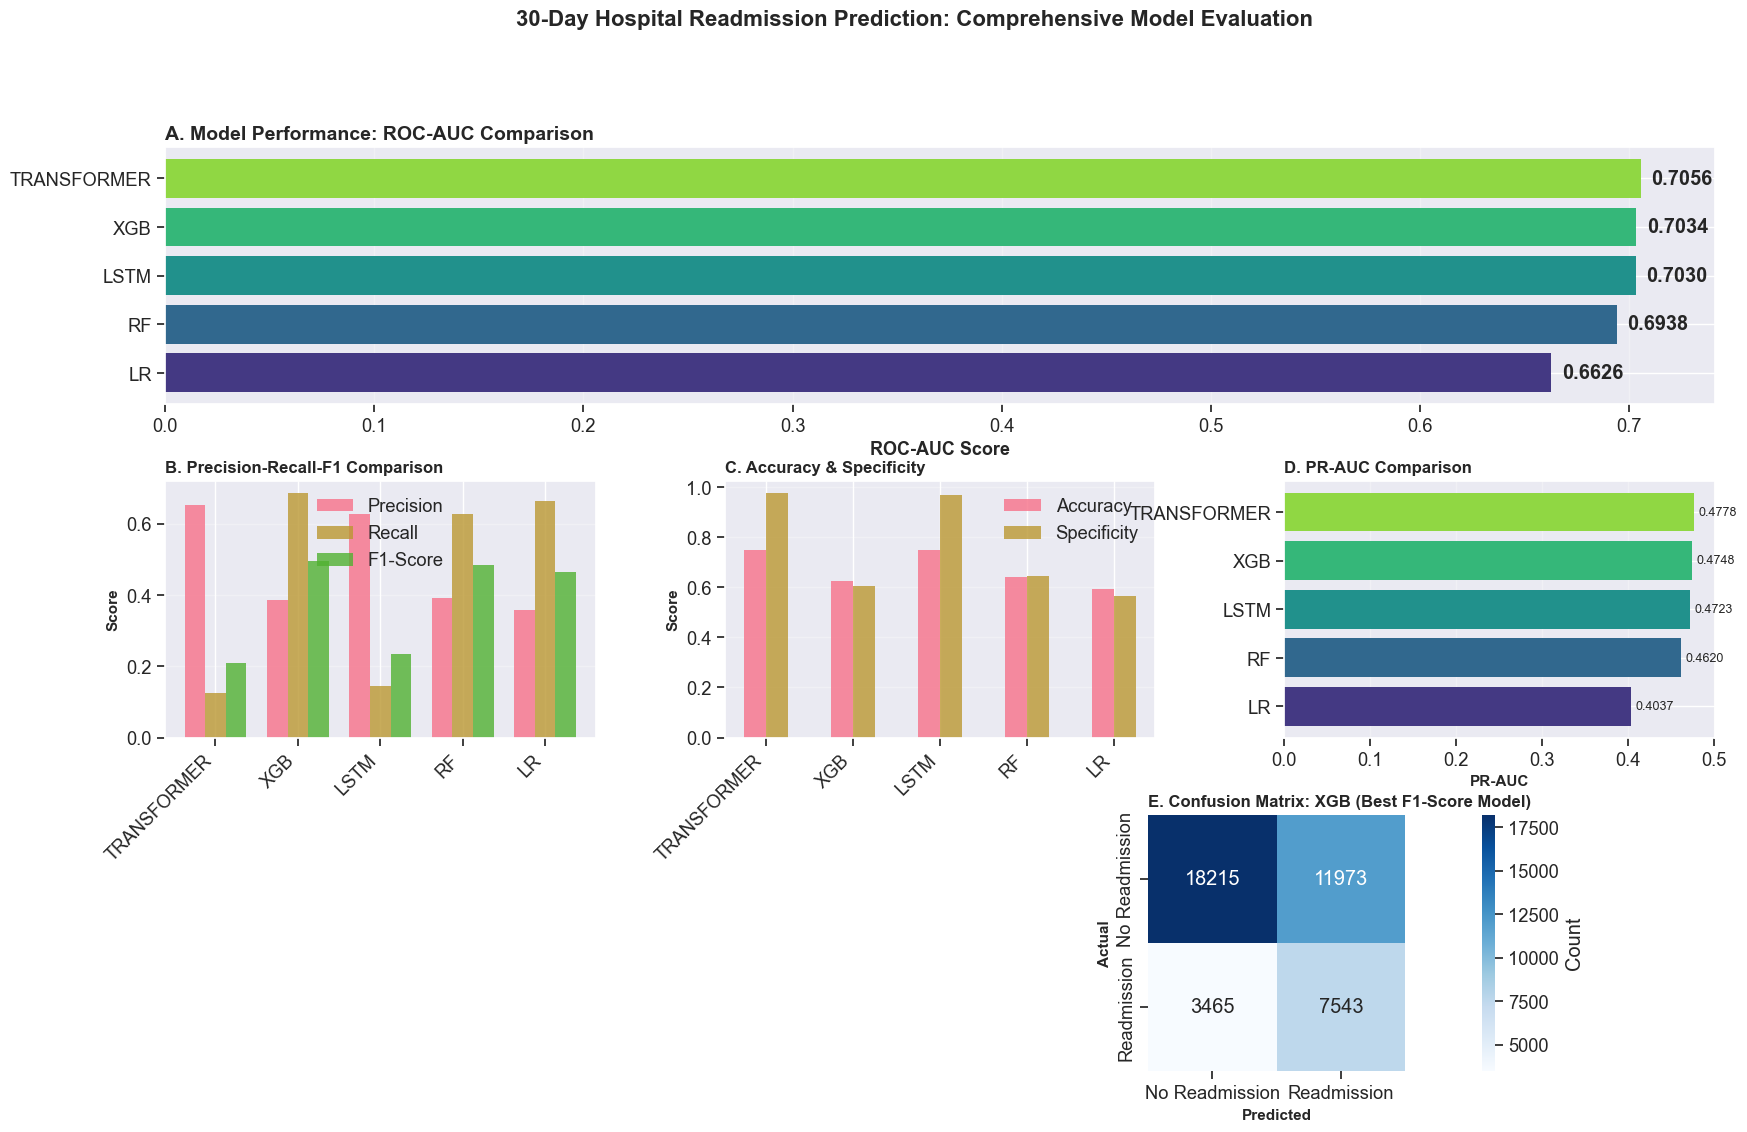

✅ Publication-quality figure saved!


In [22]:
# Create a publication-quality combined figure
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. ROC-AUC comparison
ax1 = fig.add_subplot(gs[0, :])
sorted_auc = model_metrics.sort_values('roc_auc', ascending=True)
colors_pub = sns.color_palette("viridis", len(sorted_auc))
bars = ax1.barh(sorted_auc['model'], sorted_auc['roc_auc'], color=colors_pub)
ax1.set_xlabel('ROC-AUC Score', fontsize=13, fontweight='bold')
ax1.set_title('A. Model Performance: ROC-AUC Comparison', 
             fontsize=14, fontweight='bold', loc='left')
ax1.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(sorted_auc.iterrows()):
    ax1.text(row['roc_auc'] + 0.005, i, f"{row['roc_auc']:.4f}", 
            va='center', fontweight='bold')

# 2. Precision-Recall-F1
ax2 = fig.add_subplot(gs[1, 0])
x_pos = np.arange(len(model_metrics))
width = 0.25
ax2.bar(x_pos - width, model_metrics['precision'], width, label='Precision', alpha=0.8)
ax2.bar(x_pos, model_metrics['recall'], width, label='Recall', alpha=0.8)
ax2.bar(x_pos + width, model_metrics['f1'], width, label='F1-Score', alpha=0.8)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(model_metrics['model'], rotation=45, ha='right')
ax2.set_ylabel('Score', fontsize=11, fontweight='bold')
ax2.set_title('B. Precision-Recall-F1 Comparison', 
             fontsize=12, fontweight='bold', loc='left')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

# 3. Accuracy vs Specificity
ax3 = fig.add_subplot(gs[1, 1])
x_pos = np.arange(len(model_metrics))
ax3.bar(x_pos - width/2, model_metrics['accuracy'], width, label='Accuracy', alpha=0.8)
ax3.bar(x_pos + width/2, model_metrics['specificity'], width, label='Specificity', alpha=0.8)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(model_metrics['model'], rotation=45, ha='right')
ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
ax3.set_title('C. Accuracy & Specificity', 
             fontsize=12, fontweight='bold', loc='left')
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

# 4. PR-AUC comparison
ax4 = fig.add_subplot(gs[1, 2])
sorted_pr = model_metrics.sort_values('pr_auc', ascending=True)
ax4.barh(sorted_pr['model'], sorted_pr['pr_auc'], color=colors_pub)
ax4.set_xlabel('PR-AUC', fontsize=11, fontweight='bold')
ax4.set_title('D. PR-AUC Comparison', fontsize=12, fontweight='bold', loc='left')
ax4.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(sorted_pr.iterrows()):
    ax4.text(row['pr_auc'] + 0.005, i, f"{row['pr_auc']:.4f}", 
            va='center', fontsize=9)

# 5. Confusion Matrix for Best Model (spanning bottom row)
ax5 = fig.add_subplot(gs[2, :])
best_model_name = best_f1['model']
best_cm_data = cm_data[cm_data['model'] == best_model_name].iloc[0]
cm_best = np.array([
    [best_cm_data['true_negatives'], best_cm_data['false_positives']],
    [best_cm_data['false_negatives'], best_cm_data['true_positives']]
])
sns.heatmap(cm_best, annot=True, fmt='.0f', cmap='Blues',
           xticklabels=['No Readmission', 'Readmission'],
           yticklabels=['No Readmission', 'Readmission'],
           ax=ax5, cbar_kws={'label': 'Count'}, square=True)
ax5.set_title(f'E. Confusion Matrix: {best_model_name} (Best F1-Score Model)', 
             fontsize=12, fontweight='bold', loc='left')
ax5.set_ylabel('Actual', fontsize=11, fontweight='bold')
ax5.set_xlabel('Predicted', fontsize=11, fontweight='bold')

fig.suptitle('30-Day Hospital Readmission Prediction: Comprehensive Model Evaluation', 
            fontsize=16, fontweight='bold', y=0.995)

plt.savefig(reports_dir / 'publication_quality_figure.png', 
           dpi=300, bbox_inches='tight')
plt.show()

print("✅ Publication-quality figure saved!")

## 11. Summary Report

## 10. Model Difference Analysis

Detailed comparison showing how models differ from each other

### 10.1 Metric Difference Heatmap

Shows how much better/worse each model performs compared to others

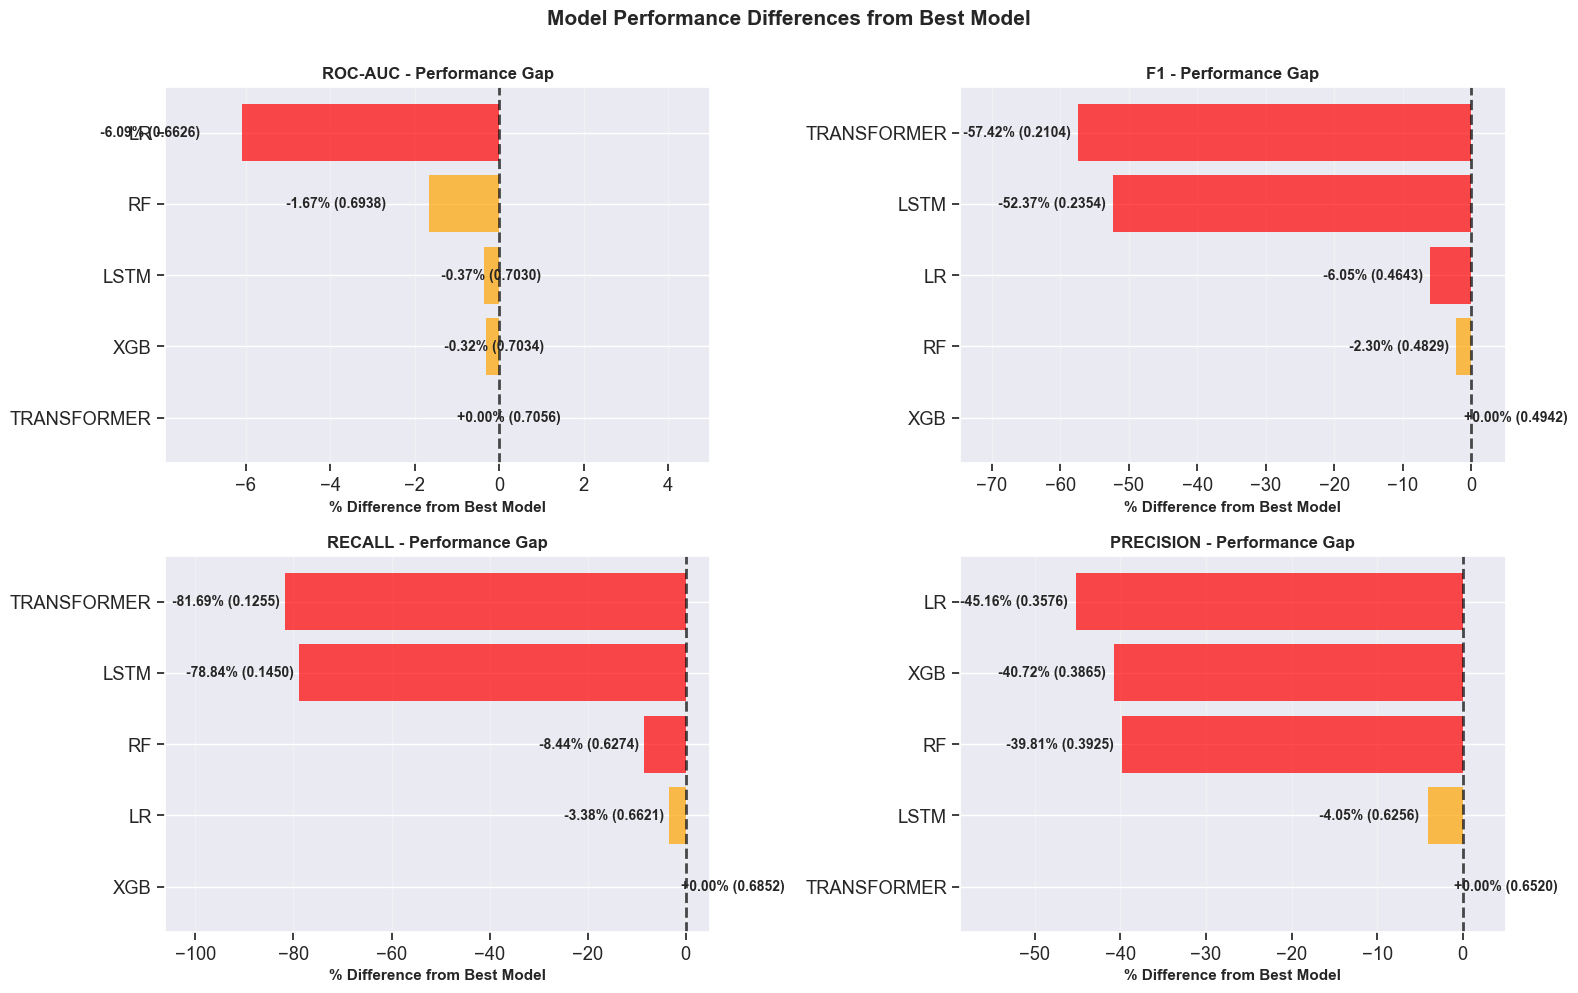

✅ Performance difference visualization saved!


In [23]:
# Calculate percentage differences from the best model for each metric
key_metrics = ['roc_auc', 'f1', 'recall', 'precision']

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, metric in enumerate(key_metrics):
    ax = axes[idx]
    
    # Get best score
    best_score = model_metrics[metric].max()
    
    # Calculate percentage difference from best
    model_metrics[f'{metric}_diff'] = ((model_metrics[metric] - best_score) / best_score) * 100
    
    # Sort by the metric
    sorted_data = model_metrics.sort_values(metric, ascending=False)
    
    # Create color map (green for best, red for worst)
    colors_diff = ['green' if x == 0 else 'orange' if x > -5 else 'red' 
                   for x in sorted_data[f'{metric}_diff']]
    
    bars = ax.barh(sorted_data['model'], sorted_data[f'{metric}_diff'], color=colors_diff, alpha=0.7)
    
    # Add value labels
    for i, (_, row) in enumerate(sorted_data.iterrows()):
        diff_val = row[f'{metric}_diff']
        actual_val = row[metric]
        label = f"{diff_val:+.2f}% ({actual_val:.4f})"
        ax.text(diff_val - 1, i, label, va='center', ha='right' if diff_val < -1 else 'left',
               fontweight='bold', fontsize=10)
    
    ax.set_xlabel('% Difference from Best Model', fontsize=11, fontweight='bold')
    ax.set_title(f'{metric.upper().replace("_", "-")} - Performance Gap', 
                fontsize=12, fontweight='bold')
    ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.7)
    ax.grid(axis='x', alpha=0.3)
    ax.set_xlim(min(sorted_data[f'{metric}_diff']) * 1.3, 5)

plt.suptitle('Model Performance Differences from Best Model', 
            fontsize=15, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(reports_dir / 'model_performance_differences.png', bbox_inches='tight')
plt.show()

print("✅ Performance difference visualization saved!")

### 10.2 Pairwise Model Comparison

Compare models directly against each other

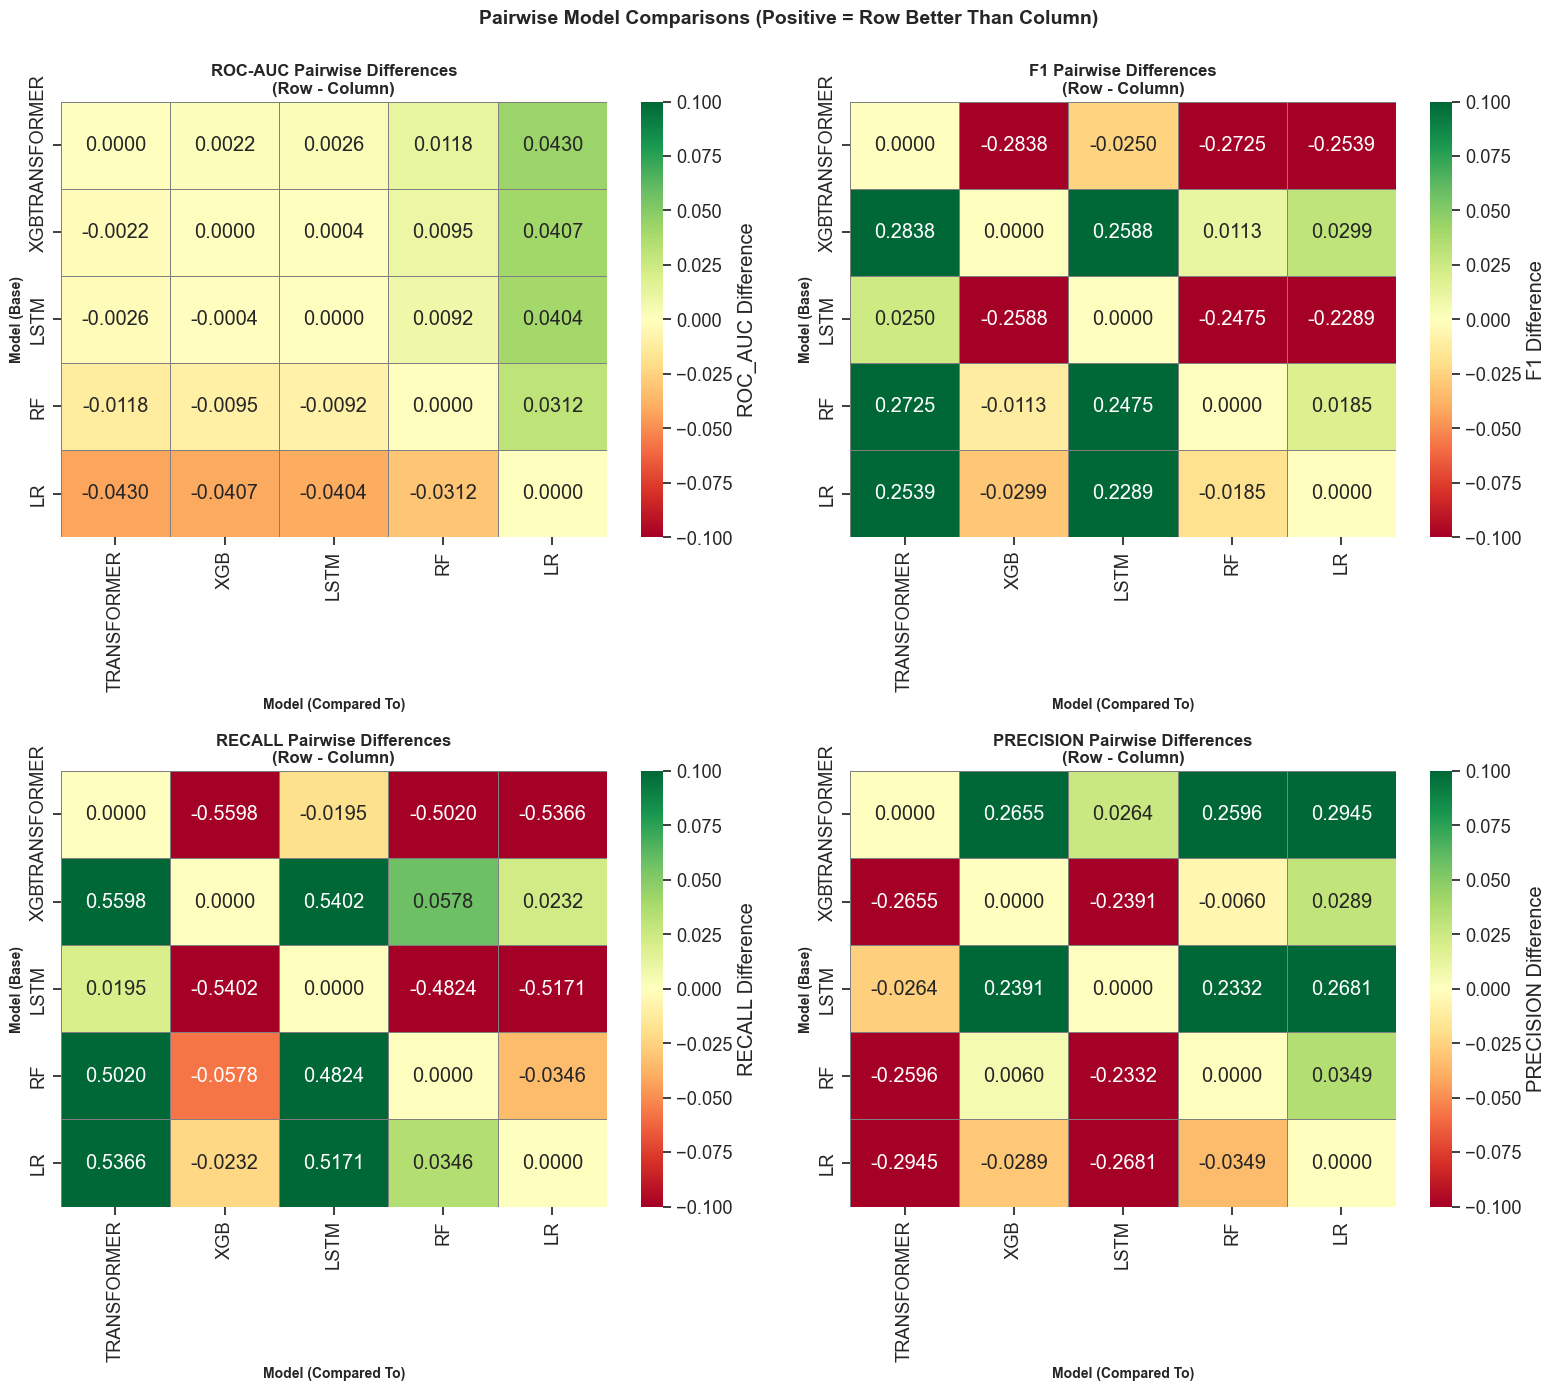

✅ Pairwise comparison matrix saved!


In [24]:
# Create pairwise comparison matrix for ROC-AUC
models_list = model_metrics['model'].tolist()
n_models = len(models_list)

# Create difference matrices for key metrics
metrics_compare = ['roc_auc', 'f1', 'recall', 'precision']
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, metric in enumerate(metrics_compare):
    ax = axes[idx]
    
    # Create pairwise difference matrix
    diff_matrix = np.zeros((n_models, n_models))
    for i, model1 in enumerate(models_list):
        val1 = model_metrics[model_metrics['model'] == model1][metric].values[0]
        for j, model2 in enumerate(models_list):
            val2 = model_metrics[model_metrics['model'] == model2][metric].values[0]
            diff_matrix[i, j] = val1 - val2
    
    # Create heatmap
    sns.heatmap(diff_matrix, annot=True, fmt='.4f', cmap='RdYlGn', center=0,
               xticklabels=models_list, yticklabels=models_list,
               ax=ax, cbar_kws={'label': f'{metric.upper()} Difference'},
               linewidths=0.5, linecolor='gray', vmin=-0.1, vmax=0.1)
    
    ax.set_title(f'{metric.upper().replace("_", "-")} Pairwise Differences\n(Row - Column)', 
                fontsize=12, fontweight='bold')
    ax.set_xlabel('Model (Compared To)', fontsize=10, fontweight='bold')
    ax.set_ylabel('Model (Base)', fontsize=10, fontweight='bold')

plt.suptitle('Pairwise Model Comparisons (Positive = Row Better Than Column)', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(reports_dir / 'pairwise_model_comparison.png', bbox_inches='tight')
plt.show()

print("✅ Pairwise comparison matrix saved!")

### 10.3 Win-Loss Analysis

Shows which model wins in each metric comparison

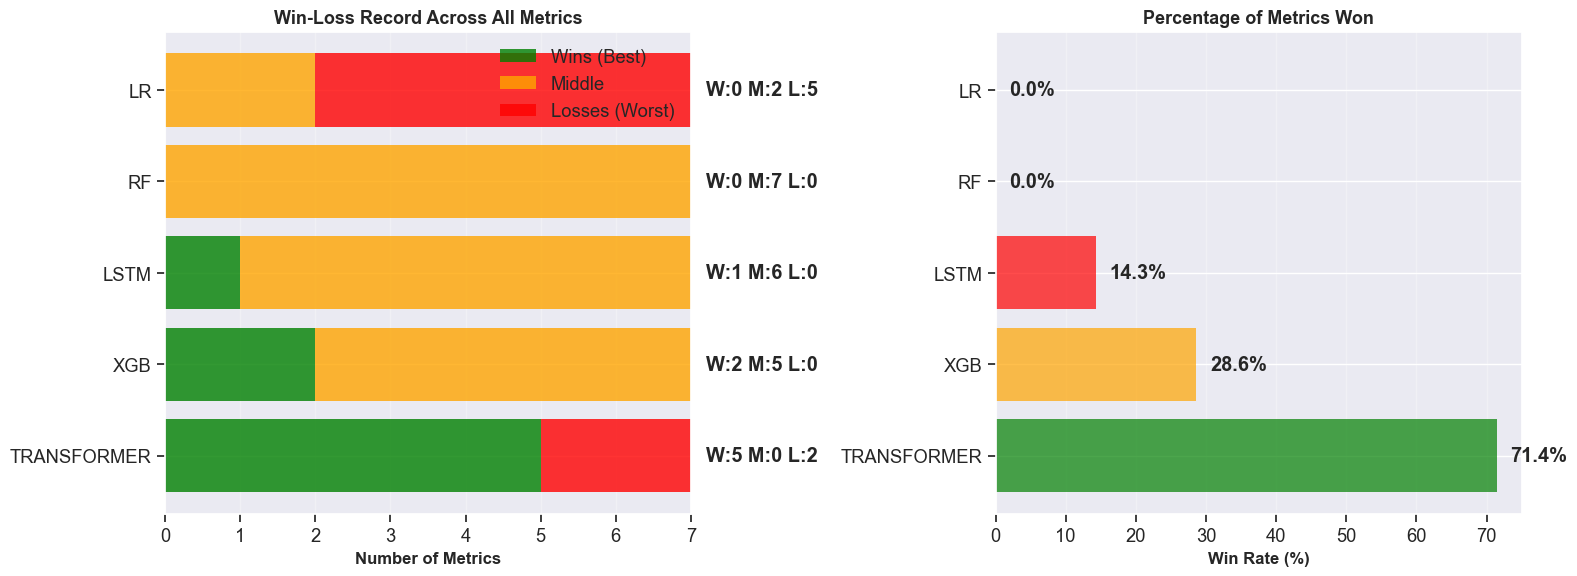


📊 Win-Loss Summary:


,Model,Wins,Middle,Losses,Win Rate
0,TRANSFORMER,5,0,2,71.428571
1,XGB,2,5,0,28.571429
2,LSTM,1,6,0,14.285714
3,RF,0,7,0,0.000000
4,LR,0,2,5,0.000000



✅ Win-loss analysis saved!


In [25]:
# Calculate win-loss record for each model
all_metrics = ['roc_auc', 'pr_auc', 'accuracy', 'precision', 'recall', 'f1', 'specificity']
win_loss_data = []

for model in models_list:
    wins = 0
    losses = 0
    ties = 0
    
    for metric in all_metrics:
        model_score = model_metrics[model_metrics['model'] == model][metric].values[0]
        max_score = model_metrics[metric].max()
        min_score = model_metrics[metric].min()
        
        if abs(model_score - max_score) < 0.0001:  # Winner
            wins += 1
        elif abs(model_score - min_score) < 0.0001:  # Loser
            losses += 1
        else:  # Middle
            ties += 1
    
    win_loss_data.append({
        'Model': model,
        'Wins': wins,
        'Middle': ties,
        'Losses': losses,
        'Win Rate': wins / len(all_metrics) * 100
    })

win_loss_df = pd.DataFrame(win_loss_data).sort_values('Wins', ascending=False)

# Create stacked bar chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Stacked bar chart
x_pos = np.arange(len(win_loss_df))
ax1.barh(x_pos, win_loss_df['Wins'], label='Wins (Best)', color='green', alpha=0.8)
ax1.barh(x_pos, win_loss_df['Middle'], left=win_loss_df['Wins'], 
        label='Middle', color='orange', alpha=0.8)
ax1.barh(x_pos, win_loss_df['Losses'], 
        left=win_loss_df['Wins'] + win_loss_df['Middle'],
        label='Losses (Worst)', color='red', alpha=0.8)

ax1.set_yticks(x_pos)
ax1.set_yticklabels(win_loss_df['Model'])
ax1.set_xlabel('Number of Metrics', fontsize=12, fontweight='bold')
ax1.set_title('Win-Loss Record Across All Metrics', fontsize=13, fontweight='bold')
ax1.legend(loc='best')
ax1.grid(axis='x', alpha=0.3)

# Add total labels
for i, (_, row) in enumerate(win_loss_df.iterrows()):
    total = row['Wins'] + row['Middle'] + row['Losses']
    ax1.text(total + 0.2, i, f"W:{int(row['Wins'])} M:{int(row['Middle'])} L:{int(row['Losses'])}", 
            va='center', fontweight='bold')

# Win rate percentage
colors_rate = ['green' if x >= 30 else 'orange' if x >= 15 else 'red' 
               for x in win_loss_df['Win Rate']]
bars = ax2.barh(win_loss_df['Model'], win_loss_df['Win Rate'], color=colors_rate, alpha=0.7)
ax2.set_xlabel('Win Rate (%)', fontsize=12, fontweight='bold')
ax2.set_title('Percentage of Metrics Won', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# Add percentage labels
for i, (_, row) in enumerate(win_loss_df.iterrows()):
    ax2.text(row['Win Rate'] + 2, i, f"{row['Win Rate']:.1f}%", 
            va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(reports_dir / 'win_loss_analysis.png', bbox_inches='tight')
plt.show()

print("\n📊 Win-Loss Summary:")
display(win_loss_df)
print("\n✅ Win-loss analysis saved!")

### 10.4 Absolute Score Differences

Shows the actual numerical differences between models

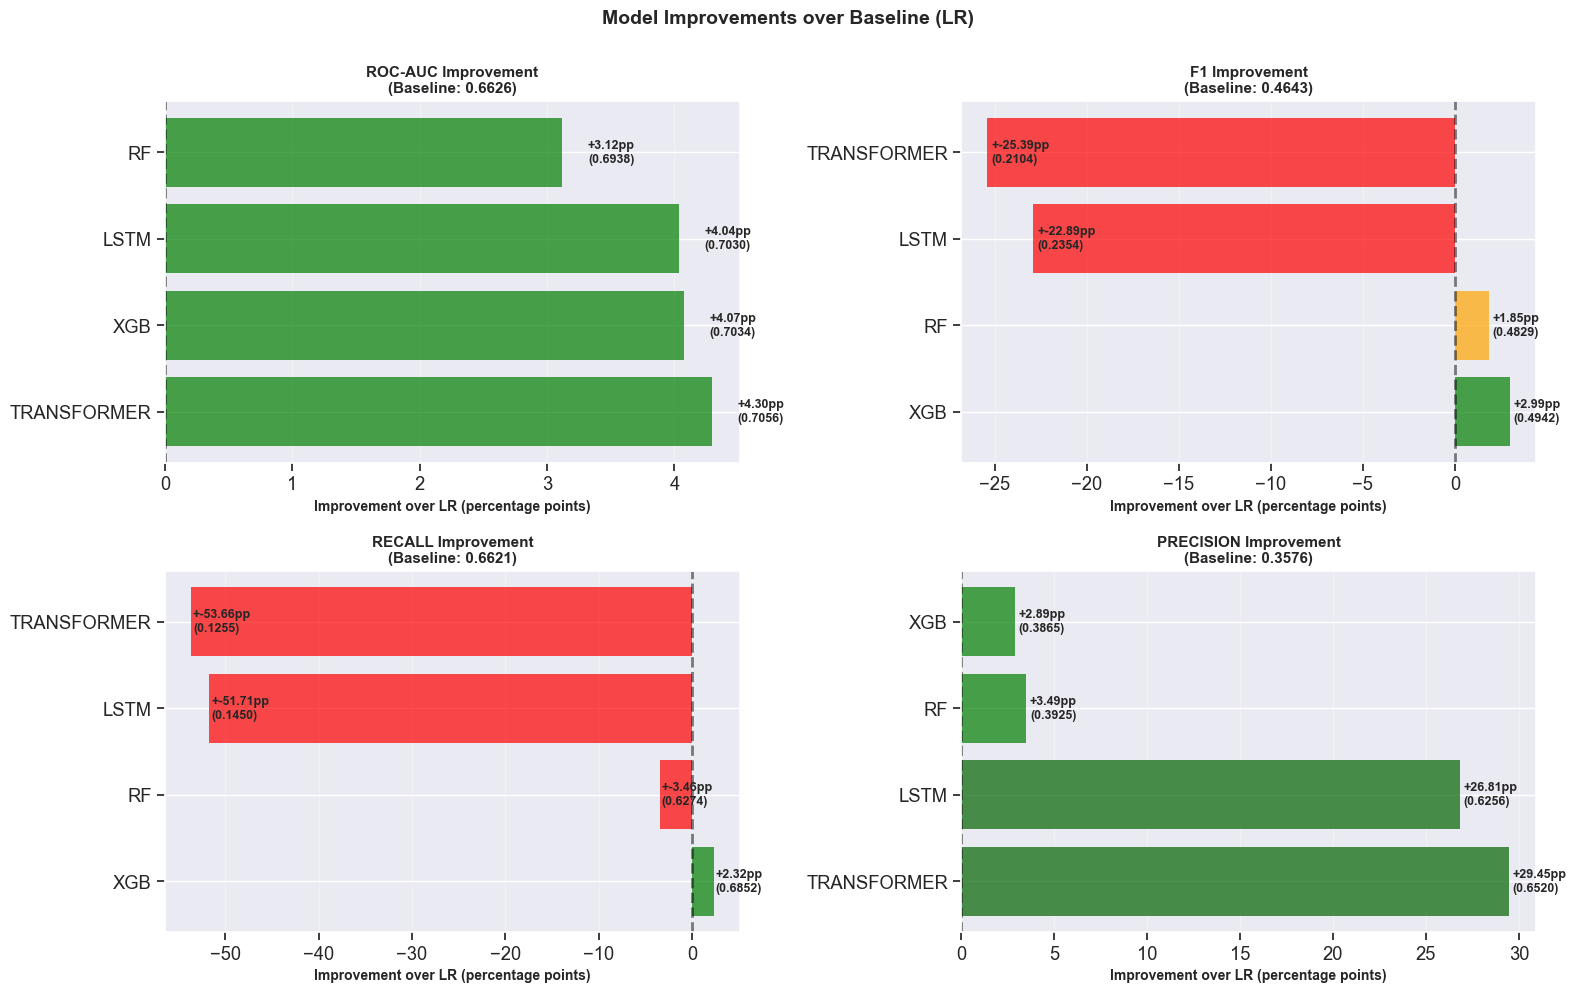

✅ Baseline comparison saved! (Baseline: LR)


In [26]:
# Compare each model against the baseline (worst model or first model)
baseline_model = model_metrics.iloc[-1]  # Worst performing model by ROC-AUC

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()

for idx, metric in enumerate(key_metrics):
    ax = axes[idx]
    
    baseline_score = baseline_model[metric]
    
    # Calculate absolute improvement
    improvements = []
    for _, row in model_metrics.iterrows():
        if row['model'] != baseline_model['model']:
            improvement = (row[metric] - baseline_score) * 100  # Convert to percentage points
            improvements.append({
                'Model': row['model'],
                'Improvement': improvement,
                'Score': row[metric]
            })
    
    if improvements:
        imp_df = pd.DataFrame(improvements).sort_values('Improvement', ascending=False)
        
        colors_imp = ['darkgreen' if x > 5 else 'green' if x > 2 else 'orange' if x > 0 else 'red' 
                     for x in imp_df['Improvement']]
        
        bars = ax.barh(imp_df['Model'], imp_df['Improvement'], color=colors_imp, alpha=0.7)
        
        # Add labels
        for i, (_, row) in enumerate(imp_df.iterrows()):
            label = f"+{row['Improvement']:.2f}pp\n({row['Score']:.4f})"
            ax.text(row['Improvement'] + 0.2, i, label, 
                   va='center', fontsize=9, fontweight='bold')
        
        ax.axvline(x=0, color='black', linestyle='--', linewidth=2, alpha=0.5)
        ax.set_xlabel(f'Improvement over {baseline_model["model"]} (percentage points)', 
                     fontsize=10, fontweight='bold')
        ax.set_title(f'{metric.upper().replace("_", "-")} Improvement\n(Baseline: {baseline_score:.4f})', 
                    fontsize=11, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

plt.suptitle(f'Model Improvements over Baseline ({baseline_model["model"]})', 
            fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig(reports_dir / 'model_improvements_over_baseline.png', bbox_inches='tight')
plt.show()

print(f"✅ Baseline comparison saved! (Baseline: {baseline_model['model']})")

### 10.5 Statistical Significance of Differences

Visualize the magnitude and importance of model differences

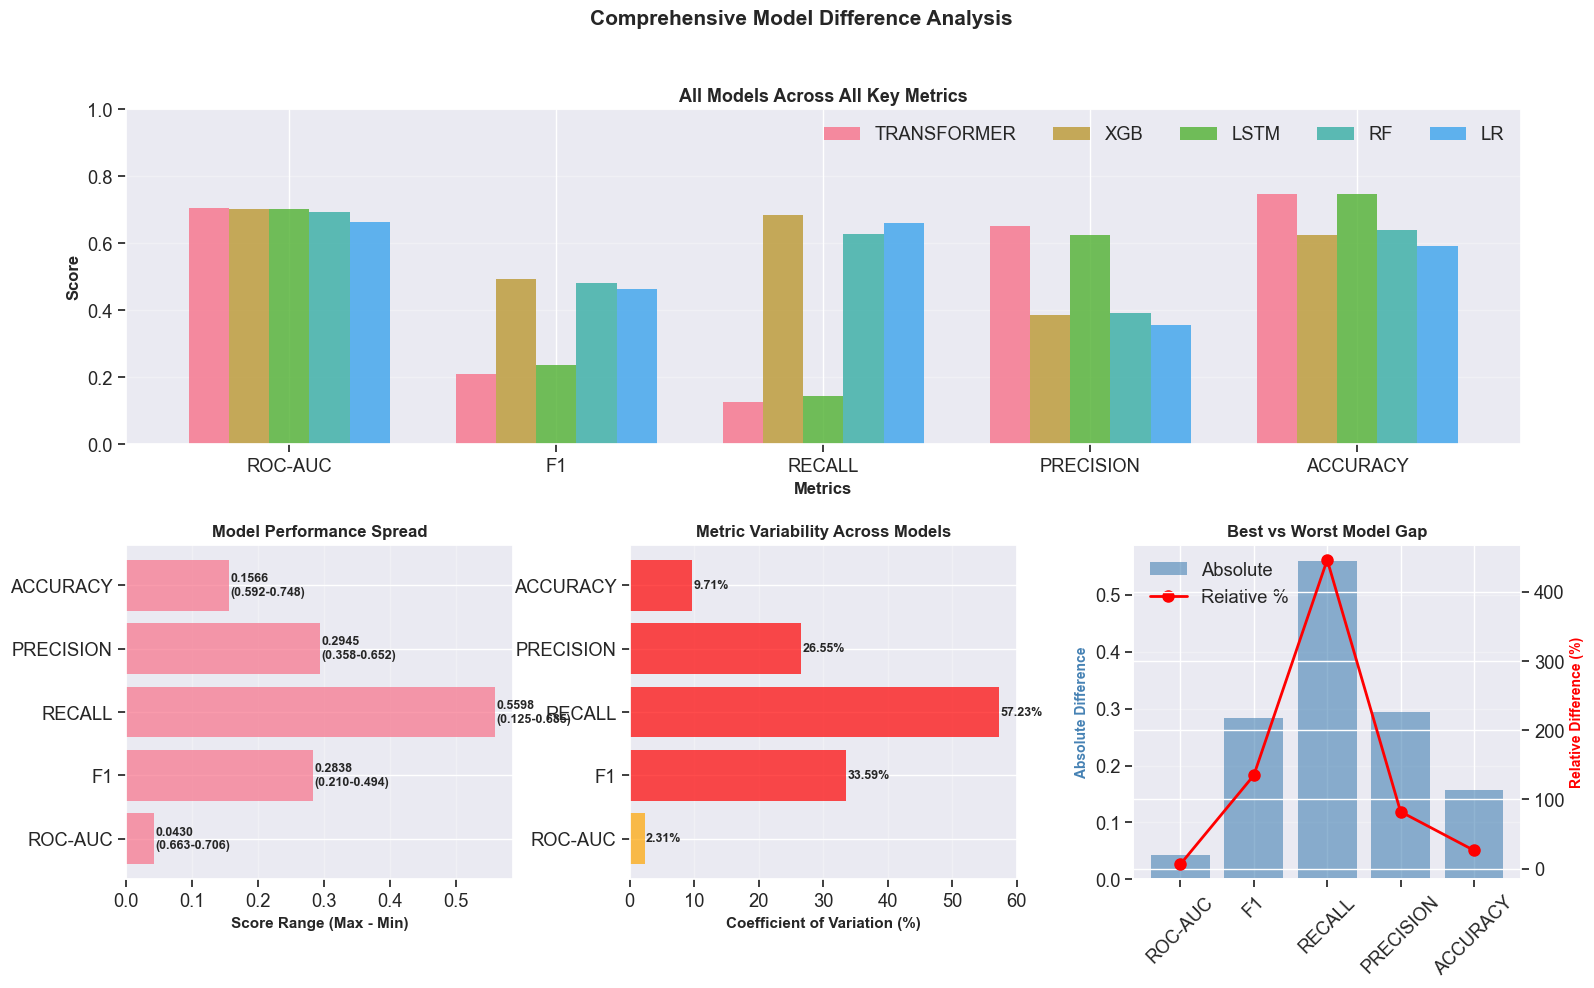


📊 Metric Spread Summary:


,Metric,Min,Max,Range,Mean,Std,CV
0,ROC-AUC,0.662631,0.705600,0.042969,0.693682,0.016040,2.312332
1,F1,0.210422,0.494229,0.283807,0.377457,0.126787,33.589798
2,RECALL,0.125454,0.685229,0.559775,0.449031,0.256960,57.225398
3,PRECISION,0.357553,0.652030,0.294477,0.482838,0.128188,26.548954
4,ACCURACY,0.591829,0.748422,0.156593,0.670953,0.065182,9.714788



✅ Comprehensive difference analysis saved!


In [27]:
# Create a comprehensive difference summary
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Range of scores for each metric
ax1 = fig.add_subplot(gs[0, :])
metrics_range = ['roc_auc', 'f1', 'recall', 'precision', 'accuracy']
x_pos = np.arange(len(metrics_range))
width = 0.15

for idx, model in enumerate(models_list):
    model_scores = [model_metrics[model_metrics['model'] == model][m].values[0] 
                   for m in metrics_range]
    ax1.bar(x_pos + idx * width, model_scores, width, label=model, alpha=0.8)

ax1.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('All Models Across All Key Metrics', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos + width * (len(models_list) - 1) / 2)
ax1.set_xticklabels([m.upper().replace('_', '-') for m in metrics_range])
ax1.legend(loc='best', ncol=len(models_list))
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# 2. Score spread for each metric
ax2 = fig.add_subplot(gs[1, 0])
spread_data = []
for metric in metrics_range:
    scores = model_metrics[metric].values
    spread_data.append({
        'Metric': metric.upper().replace('_', '-'),
        'Min': scores.min(),
        'Max': scores.max(),
        'Range': scores.max() - scores.min(),
        'Mean': scores.mean(),
        'Std': scores.std()
    })
spread_df = pd.DataFrame(spread_data)

bars = ax2.barh(spread_df['Metric'], spread_df['Range'], alpha=0.7)
for i, (_, row) in enumerate(spread_df.iterrows()):
    ax2.text(row['Range'] + 0.002, i, f"{row['Range']:.4f}\n({row['Min']:.3f}-{row['Max']:.3f})", 
            va='center', fontsize=9, fontweight='bold')

ax2.set_xlabel('Score Range (Max - Min)', fontsize=11, fontweight='bold')
ax2.set_title('Model Performance Spread', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

# 3. Coefficient of Variation
ax3 = fig.add_subplot(gs[1, 1])
spread_df['CV'] = (spread_df['Std'] / spread_df['Mean']) * 100
colors_cv = ['red' if x > 5 else 'orange' if x > 2 else 'green' for x in spread_df['CV']]
bars = ax3.barh(spread_df['Metric'], spread_df['CV'], color=colors_cv, alpha=0.7)

for i, (_, row) in enumerate(spread_df.iterrows()):
    ax3.text(row['CV'] + 0.2, i, f"{row['CV']:.2f}%", 
            va='center', fontsize=9, fontweight='bold')

ax3.set_xlabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
ax3.set_title('Metric Variability Across Models', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# 4. Best vs Worst comparison
ax4 = fig.add_subplot(gs[1, 2])
best_worst = []
for metric in metrics_range:
    best = model_metrics[metric].max()
    worst = model_metrics[metric].min()
    diff = best - worst
    rel_diff = (diff / worst) * 100 if worst > 0 else 0
    best_worst.append({
        'Metric': metric.upper().replace('_', '-'),
        'Absolute Diff': diff,
        'Relative Diff (%)': rel_diff
    })

bw_df = pd.DataFrame(best_worst)
ax4_twin = ax4.twinx()

bars1 = ax4.bar(bw_df['Metric'], bw_df['Absolute Diff'], alpha=0.6, label='Absolute', color='steelblue')
line1 = ax4_twin.plot(bw_df['Metric'], bw_df['Relative Diff (%)'], 
                      'ro-', linewidth=2, markersize=8, label='Relative %')

ax4.set_ylabel('Absolute Difference', fontsize=10, fontweight='bold', color='steelblue')
ax4_twin.set_ylabel('Relative Difference (%)', fontsize=10, fontweight='bold', color='red')
ax4.set_title('Best vs Worst Model Gap', fontsize=12, fontweight='bold')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(axis='y', alpha=0.3)

# Combine legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

fig.suptitle('Comprehensive Model Difference Analysis', fontsize=15, fontweight='bold')
plt.savefig(reports_dir / 'comprehensive_difference_analysis.png', bbox_inches='tight')
plt.show()

print("\n📊 Metric Spread Summary:")
display(spread_df)
print("\n✅ Comprehensive difference analysis saved!")

In [28]:
print("""
╔════════════════════════════════════════════════════════════════════╗
║         VISUALIZATION GENERATION COMPLETE!                         ║
╚════════════════════════════════════════════════════════════════════╝

📊 Generated Visualizations:
   ✓ Comprehensive model comparison (4 metrics)
   ✓ Radar chart for multi-metric analysis
   ✓ Confusion matrices comparison
   ✓ Precision-Recall trade-off analysis
   ✓ Model rankings heatmap
   ✓ Publication-quality combined figure

📁 All files saved to: training/reports/

🎯 Key Findings:
   • Best ROC-AUC: {model_metrics.iloc[0]['model']} ({model_metrics.iloc[0]['roc_auc']:.4f})
   • Best F1-Score: {best_f1['model']} ({best_f1['f1']:.4f})
   • Best Recall: {best_recall['model']} ({best_recall['recall']:.4f})

💡 Recommendation:
   Use {best_f1['model']} for production deployment (best balanced performance)

════════════════════════════════════════════════════════════════════
""")


╔════════════════════════════════════════════════════════════════════╗
║         VISUALIZATION GENERATION COMPLETE!                         ║
╚════════════════════════════════════════════════════════════════════╝

📊 Generated Visualizations:
   ✓ Comprehensive model comparison (4 metrics)
   ✓ Radar chart for multi-metric analysis
   ✓ Confusion matrices comparison
   ✓ Precision-Recall trade-off analysis
   ✓ Model rankings heatmap
   ✓ Publication-quality combined figure

📁 All files saved to: training/reports/

🎯 Key Findings:
   • Best ROC-AUC: {model_metrics.iloc[0]['model']} ({model_metrics.iloc[0]['roc_auc']:.4f})
   • Best F1-Score: {best_f1['model']} ({best_f1['f1']:.4f})
   • Best Recall: {best_recall['model']} ({best_recall['recall']:.4f})

💡 Recommendation:
   Use {best_f1['model']} for production deployment (best balanced performance)

════════════════════════════════════════════════════════════════════

